In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import os
import glob
import pickle
from collections import Counter
import itertools

import re
from tqdm import tqdm

import statsmodels.api as sm
import scipy.stats as sts
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA = './data'
MY_DATA = './my_data'
ANSW = './answers'

# подготовка нескольких обучающих выборок для сравнения

In [4]:
def prepare_sparse_train_set_window(path_to_csv, path_to_site_freq, sess_len, wind_size):
    
    rows = 0
    site_cnt = []
    ret_userid_list = []
    # form dataframe names ['site1, site2......site{session_length}']
    col_names = ['site' + str(n+1) for n in range(sess_len)]

    #pkl_name = 'site_freq_' + str(re.findall('\d+', path_to_data)[0]) + 'users.pkl'
    with open(path_to_site_freq, 'rb') as f:
        freq_site_dict = pickle.load(f)


    # getting size of DataFrame
    # collect all sites ans them frequencies
    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
        temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
        site_cnt += list(temp_dataframe.site.values)
        rows += round(temp_dataframe.shape[0] / wind_size + 0.499)

    site_cnt = Counter(site_cnt)

    # ceate DataFrame of known size
    ret_data = pd.DataFrame(index = range(rows), columns = col_names)
    index = 0


    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
            temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
            userid = int(re.findall('\d+', file_csv)[1])


            sess_numb = round(temp_dataframe.shape[0] / wind_size + 0.499)
            for idx in range(sess_numb - 1):
                #new dict for current session
                new_sess = {('site' + str(n+1)):0 for n in range(sess_len)}

                sess_start = idx*wind_size
                sess_end   = idx*wind_size + sess_len

                for n, site in enumerate(temp_dataframe.site.values[sess_start : sess_end]):
                    new_sess['site' + str(n+1)] = freq_site_dict[site][0]
                #new_sess['user_id'] = userid
                ret_userid_list.append(userid)
                
                #put data in prepared DataFrame
                ret_data.iloc[index] = new_sess
                index += 1


            new_sess = {('site' + str(n+1)):0 for n in range(sess_len)}
            for n, site in enumerate(temp_dataframe.site.values[(sess_numb-1)*wind_size: ]):
                new_sess['site' + str(n+1)] = freq_site_dict[site][0]
            #new_sess['user_id'] = userid
            ret_userid_list.append(userid)

            ret_data.iloc[index] = new_sess
            index += 1
        
    ret_csr = to_sitebow_csr(ret_data.values)
    
    return ret_csr, ret_userid_list

In [5]:
def to_sitebow_csr(inp_data):
    row  = []
    col  = []
    data = []
    for idx, elmnt in enumerate(inp_data):
        cnt = Counter(elmnt)        # for each string get {'site': how many in string}
        
        row += [idx] * len(cnt)     # row number in which value is parse
        data+= list(cnt.values())   # value
        col += list(cnt.keys())     # column number in which value is parse
        
    ret = csr_matrix((data, (row, col)), shape = (max(row)+1, max(col)+1))[:, 1:]
    
    return ret

In [6]:
csr_data, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(DATA, '3users'),
                                             os.path.join(MY_DATA, 'site_freq_3users.pkl'),
                                             5, 3)

In [7]:
csr_data.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
y_s5_w3

[1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3]

In [9]:
def prepare_sparse_train_set_window_v2(path_to_csv, path_to_site_freq, sess_len, wind_size):
    
    #rows = 0
    #site_cnt = []
    ret_userid_list = []
    # form dataframe names ['site1, site2......site{session_length}']
    col_names = ['site' + str(n+1) for n in range(sess_len)]

    #pkl_name = 'site_freq_' + str(re.findall('\d+', path_to_data)[0]) + 'users.pkl'
    with open(path_to_site_freq, 'rb') as f:
        freq_site_dict = pickle.load(f)

    row_csr  = []
    col_csr  = []
    data_csr = []
        
    # getting size of DataFrame
    # collect all sites ans them frequencies
    #for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
    #    temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
    #    site_cnt += list(temp_dataframe.site.values)
    #    rows += round(temp_dataframe.shape[0] / wind_size + 0.499)

    #site_cnt = Counter(site_cnt)

    # ceate DataFrame of known size
    #ret_data = pd.DataFrame(index = range(rows), columns = col_names)
    index = 0


    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
            temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
            userid = int(re.findall('\d+', file_csv)[1])


            sess_numb = round(temp_dataframe.shape[0] / wind_size + 0.499)
            for idx in range(sess_numb - 1):
                #new dict for current session
                new_sess = {('site' + str(n+1)):0 for n in range(sess_len)}

                sess_start = idx*wind_size
                sess_end   = idx*wind_size + sess_len

                for n, site in enumerate(temp_dataframe.site.values[sess_start : sess_end]):
                    new_sess['site' + str(n+1)] = freq_site_dict[site][0]
                #new_sess['user_id'] = userid
                ret_userid_list.append(userid)
                
                cnt_csr = Counter(new_sess.values())
                #print(len(cnt_csr))
                #print()
                #print(cnt_csr.values())
                #print()
                row_csr += [index] * len(cnt_csr)     # row number in which value is parse
                data_csr+= list(cnt_csr.values())   # value
                #print(cnt_csr.keys())
                #for site_n in cnt_csr.keys():
                col_csr += list(cnt_csr.keys())     # column number in which value is parse
                    #print(type(int(re.findall('\d+', site_n)[0])))
                    #col_csr += [int(re.findall('\d+', site_n)[0])]
                #put data in prepared DataFrame
                #ret_data.iloc[index] = new_sess
                index += 1


            new_sess = {('site' + str(n+1)):0 for n in range(sess_len)}
            for n, site in enumerate(temp_dataframe.site.values[(sess_numb-1)*wind_size: ]):
                new_sess['site' + str(n+1)] = freq_site_dict[site][0]
            #new_sess['user_id'] = userid
            ret_userid_list.append(userid)
            cnt_csr = Counter(new_sess.values())
            row_csr += [index] * len(cnt_csr)     # row number in which value is parse
            data_csr+= list(cnt_csr.values())   # value
            #for site_n in cnt_csr.keys():
            col_csr += list(cnt_csr.keys())     # column number in which value is parse
            #    col_csr += [int(re.findall('\d+', site_n)[0])]
                

            #ret_data.iloc[index] = new_sess
            index += 1
        
    #ret_csr = to_sitebow_csr(ret_data.values)
   # 
   # 
   #     for idx, elmnt in enumerate(inp_data):
   #     cnt = Counter(elmnt)        # for each string get {'site': how many in string}
   #     
   #     row += [idx] * len(cnt)     # row number in which value is parse
   #     data+= list(cnt.values())   # value
   #     col += list(cnt.keys())     # column number in which value is parse#
    #print(data_csr)
    #print(col_csr)
    ret_csr = csr_matrix((data_csr, (row_csr, col_csr)), shape = (max(row_csr)+1, max(col_csr)+1))[:, 1:]
    
    return ret_csr, ret_userid_list

In [10]:
csr_data_v2, y_s5_w3 = prepare_sparse_train_set_window_v2(os.path.join(DATA, '3users'),
                                             os.path.join(MY_DATA, 'site_freq_3users.pkl'),
                                             5, 3)

In [11]:
csr_data_v2.toarray()

array([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
%%time
data_length = []

for n_users in [10, 150]:
    for w_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
        if w_size <= session_length and (w_size, session_length) != (10, 10):
            #print(w_size, session_length, n_users)
            direct_name = str(n_users) + 'users'
            pickle_name = 'site_freq_' + str(n_users) + 'users.pkl'
            x, y = prepare_sparse_train_set_window_v2(os.path.join(DATA, direct_name),
                                               os.path.join(MY_DATA, pickle_name),
                                               session_length, 
                                               w_size, 
                                               )
            data_length.append(x.shape[0])
            #pkl_name_x = f'X_sparse_{n_users}users_s{session_length}_w{w_size}.pkl'
            #pkl_name_y = f'Y_sparse_{n_users}users_s{session_length}_w{w_size}.pkl'
            
            #with open(os.path.join(MY_DATA, pkl_name_x), 'wb') as x_pkl:
            #    pickle.dump(x, x_pkl, protocol = 2)
    
            #with open(os.path.join(MY_DATA, pkl_name_y), 'wb') as y_pkl:
            #    pickle.dump(y, y_pkl, protocol = 2)
            

12it [00:03,  3.04it/s]
12it [00:39,  3.32s/it]

CPU times: user 43.8 s, sys: 72 ms, total: 43.8 s
Wall time: 43.8 s


In [21]:
print(data_length)

[14061, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 137019, 195712, 195712, 195712, 273957, 273957, 273957, 273957]


In [16]:
def write_answer_to_file(answer, file_address):
    if isinstance(answer, list) or isinstance(answer, np.ndarray):
        with open(os.path.join(ANSW, file_address), 'w') as out_f:
            for idx, elmnt in enumerate(answer):
                if idx == 0:
                    out_f.write(str(elmnt))
                else:
                    out_f.write(' ' + str(elmnt))
    else:
        with open(os.path.join(ANSW, file_address), 'w') as out_f:
            out_f.write(str(answer))

In [17]:
write_answer_to_file(data_length, 'answer2_1.txt')

# первичный анализ данных, проверка гипотез

In [22]:
train_df = pd.read_csv(os.path.join(MY_DATA, 'train_data_10users.csv'),
                      index_col = 'session_id'
                      )

In [23]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,31
1,415,193,674,254,133,31,393,3305,217,55,31
2,55,3,55,55,5,293,415,333,897,55,31
3,473,3306,473,55,55,55,55,937,199,123,31
4,342,55,5,3307,258,211,3308,2086,675,2086,31


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [25]:
train_df.user_id.value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

In [26]:
num_uniq_sites = [np.unique(train_df.values[i, :-1]).shape[0]
                 for i in range(train_df.shape[0])]

len(num_uniq_sites)

14061

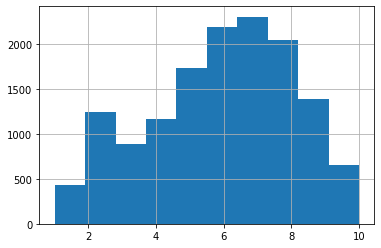

In [27]:
pd.Series(num_uniq_sites).hist();

проверим распределено ли кол-во уникальных сайтов в каждой сессии нормально

((array([-3.89403843, -3.6734386 , -3.55253248, ...,  3.55253248,
          3.6734386 ,  3.89403843]), array([ 1,  1,  1, ..., 10, 10, 10])),
 (2.308739910778148, 5.951923760756702, 0.9770787039552056))

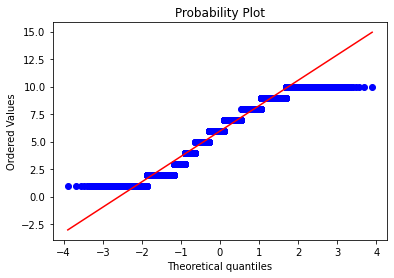

In [28]:
sts.probplot(num_uniq_sites, plot=plt)

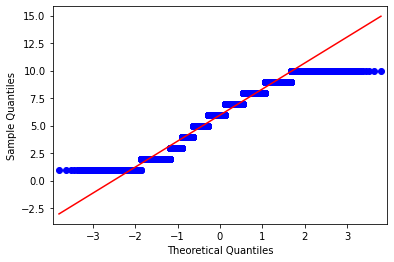

In [29]:
fig = sm.qqplot(np.array(num_uniq_sites), sts.norm, line = 's')
plt.show()

In [30]:
stat, p = sts.shapiro(num_uniq_sites)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.955, p=0.00000000


/home/voloch/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [31]:
alpha = 0.05
if p > alpha:
    answ2 = 'YES'
else:
    answ2 = 'NO'

In [32]:
write_answer_to_file(answ2, 'answer2_2.txt')

**Проверьте гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратите внимание, что альтернатива тому, что доля равна 95% –  одностороняя).**

In [33]:
has_two_similar = (np.array(num_uniq_sites) < 10).astype('int')
has_two_similar

array([1, 0, 1, ..., 1, 1, 1])

In [34]:
p_val = sts.binom_test(sum(has_two_similar), len(has_two_similar), p = 0.95, alternative='greater')
answ3 = p_val
answ3

0.02207653769072678

In [35]:
write_answer_to_file(answ3, 'answer2_3.txt')

**Поcмотрим для этой доли 95% доверительный интервал Уилсона**

In [36]:
wilson_int = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')
wilson_int

(0.9501028841411286, 0.9570527377232229)

In [37]:
answ4 = [round(wilson_int[0], 3), round(wilson_int[1], 3)]
answ4

[0.95, 0.957]

In [38]:
write_answer_to_file(answ4, 'answer2_4.txt')

In [39]:
with open(os.path.join(MY_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    freq_site_dict = pickle.load(f)

**Постройте распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.**

In [43]:
with open(os.path.join(MY_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    sites = pickle.load(f)

In [45]:
len(sites)

4913

In [87]:
freq_sites = [el[1] for el in sites.values()]
freq_ind = [el[0] for el in sites.values()]

**Постройте 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используйте столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Берите подвыборки из посчитанного списка частот посещений сайтов – не надо заново считать эти частоты. Учтите, что частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) включать не надо. Округлите границы интервала до 3 знаков после запятой и запишите через пробел в файл *answer2_5.txt*. Это будет ответом на 5 вопрос теста.**

In [172]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [173]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [174]:
freq_data = pd.DataFrame({'freq': freq_sites}, index = freq_ind)

предполагаем, что текущие данные лишь одна из возможных     
выборок генеральной совокупности.     
генерируем другие возможные выборки

In [175]:
freq_samples = map(np.mean, get_bootstrap_samples(freq_data.freq.values, len(sites)))

In [176]:
gg = stat_intervals(list(freq_samples), 0.05)

In [177]:
gg

array([22.51524527, 35.76303684])

In [178]:
answ5 = [round(gg[0], 3), round(gg[1], 3)]
answ5

[22.515, 35.763]

In [179]:
write_answer_to_file(answ5, 'answer2_5.txt')